In [14]:
import pytest
import numpy as np
import scipy as sp


from scipy.misc import imread, imshow
from scipy.ndimage import affine_transform

from matplotlib import pyplot as plt

%matplotlib inline

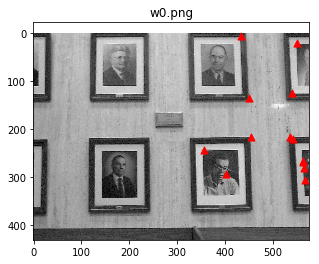

In [15]:
# Look at the test data
plt.title('w0.png')
plt.imshow(w0, cmap='gray')
plt.scatter(corr0[:, 0], corr0[:, 1], s=50, c='r', marker='^')

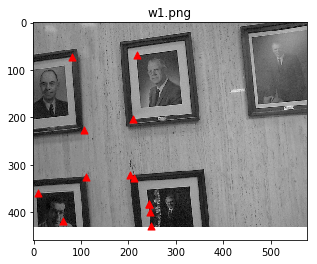

In [16]:
plt.title('w1.png')
plt.imshow(w1, cmap='gray')
plt.scatter(corr1[:, 0], corr1[:, 1], s=50, c='r', marker='^')

# Function for computing affine transform in any dimension and metrics for images

In [17]:
def augment(points):
    return np.hstack([points, np.ones((points.shape[0], 1))])

def compute_affine_transform(X, Y):
    #affine_mat = X.T.dot(np.linalg.pinv(Y.T))
    #return affine_mat if not sep else affine_mat[:-1, :-1], affine_mat[:-1, -1]
    affine_mat = np.linalg.lstsq(X, Y)[0].T
    mat, shift = affine_mat[:-1, :-1], affine_mat[:-1, -1]
    mat, shift = np.linalg.pinv(mat), -shift
    return mat, shift

In [19]:
### Metrics
def MSE(x, y, axis=None):
    return np.mean((x - y)**2)

def MAE(x, y, axis=None):
    return np.mean(np.abs(x - y))

In [20]:
def img_difference(img_from, img_to, ps_from, ps_to, diff_func=MSE):
    ps1, ps2 = map(augment, [ps_from, ps_to])
    mat, shift = compute_affine_transform(ps1, ps2)
    img_transformed = affine_transform(img_from.astype(np.float), mat.T, shift[::-1], cval=-1)
    mask = np.array(~(img_transformed == -1), dtype=np.float)
    img_transformed = affine_transform(img_from.astype(np.float), mat.T, shift[::-1])
    difference = diff_func(img_transformed * mask, img_to * mask)
    return difference

def transformed_difference(images, point_sets, diff_func=MSE):
    # calculate forward diff
    forward_diff = img_difference(*images, *point_sets, diff_func=diff_func)
    
    # and backward
    backward_diff = img_difference(*images[::-1], *point_sets[::-1], diff_func=diff_func)
    return forward_diff, backward_diff

def test_transformed_difference():
    corr0 = np.loadtxt('correspondence2D_w0.txt')
    corr1 = np.loadtxt('correspondence2D_w1.txt')
    
    w0 = imread('w0.png')
    w1 = imread('w1.png')
    
    print("MSE on affine transformed overlapping: {}".format(transformed_difference([w0, w1], [corr0, corr1], diff_func=MSE)))
    print("MAE on affine transformed overlapping: {}".format(transformed_difference([w0, w1], [corr0, corr1], diff_func=MAE)))
    print("MSE on images: {}".format(MSE(w0, w1)))
    print("MAE on images: {}".format(MAE(w0, w1)))

In [21]:
test_transformed_difference()

MSE on affine transformed overlapping: (622.66334182396008, 1096.578109148862)
MAE on affine transformed overlapping: (9.8533818992174886, 16.673554041633434)
MSE on images: 107.9261188271605
MAE on images: 160.41975308641975


In [22]:
corr0 = np.loadtxt('correspondence2D_w0.txt')
corr1 = np.loadtxt('correspondence2D_w1.txt')

w0 = imread('w0.png')
w1 = imread('w1.png')

mat, shift = compute_affine_transform(augment(corr0), augment(corr1))

In [23]:
(np.linalg.pinv(mat) @ corr0.T - shift[::, None]).T - corr1

array([[ 1.0709526 , -7.02218807],
       [ 2.10367293, -2.54295705],
       [-1.86035792,  3.34185392],
       [-4.0072412 ,  8.55266902],
       [ 3.48532833, -2.11619303],
       [-1.25846816,  1.01619665],
       [ 5.68869959, -2.02065775],
       [-3.76091662,  2.57402405],
       [-1.95501203,  5.07832412],
       [ 4.25745939, -3.15920888],
       [-1.41572783, -2.68413756],
       [-1.36847246, -0.28465295],
       [-0.97991662, -0.73307248]])

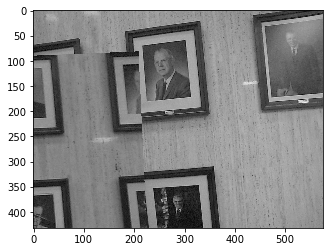

In [24]:
#affine transform
img_transformed = affine_transform(w0.astype(np.float), mat.T, shift[::-1], cval=-1)
mask = np.array(~(img_transformed == -1), dtype=np.float)
img_transformed = affine_transform(w0.astype(np.float), mat.T, shift[::-1])
img_transformed = img_transformed * mask + w1 * (1.0 - mask)

plt.imshow(img_transformed, cmap='gray')